In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 200

mu_scales = [0.5, 0.1, 0.05, 0.01]
beta = 0.0001

In [4]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=n=1000$

In [5]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)


mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4881e-01, fro_norm=7.0724e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4729e-01, fro_norm=7.0803e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1526e-01, fro_norm=1.2542e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1548e-01, fro_norm=1.2543e+00
lamb_max=3.7620e+00, mu_max=2.0508e+01


In [6]:
residuals = {}
for mu_scale in mu_scales:
    mu_reg = max(mu_scale * mu_max, 1e-6)
    residuals[mu_scale] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.007453778397428


obj (diag scaling):  -0.15341544151306152 
constraint viol (diag scaling):  0.8332904437556862
lamb_max=10.007453778397428
obj (vanilla):  -0.15341462194919586 
constraint viol (vanilla):  0.810112444218248
lamb_max=10.007453778397428
obj (acceleration):  -0.1532728224992752 
constraint viol (acceleration):  0.021368225337937426
obj (fista):  -0.15327873826026917 
constraint viol (fista):  0.0029114491771906133
lamb_max=10.007453778397428
obj (diag scaling):  -0.7171106934547424 
constraint viol (diag scaling):  3.1266894550062716
lamb_max=10.007453778397428
obj (vanilla):  -0.711340069770813 
constraint viol (vanilla):  2.8540404057130218
lamb_max=10.007453778397428
obj (acceleration):  -0.6293612718582153 
constraint viol (acceleration):  0.5733280451968311
obj (fista):  -0.6367477774620056 
constraint viol (fista):  0.056935216183774125
lamb_max=10.007453778397428
obj (diag scaling):  -1.2575671672821045 
constraint viol (diag scaling):  3.431537236087024
lamb_max=10.007453778397428

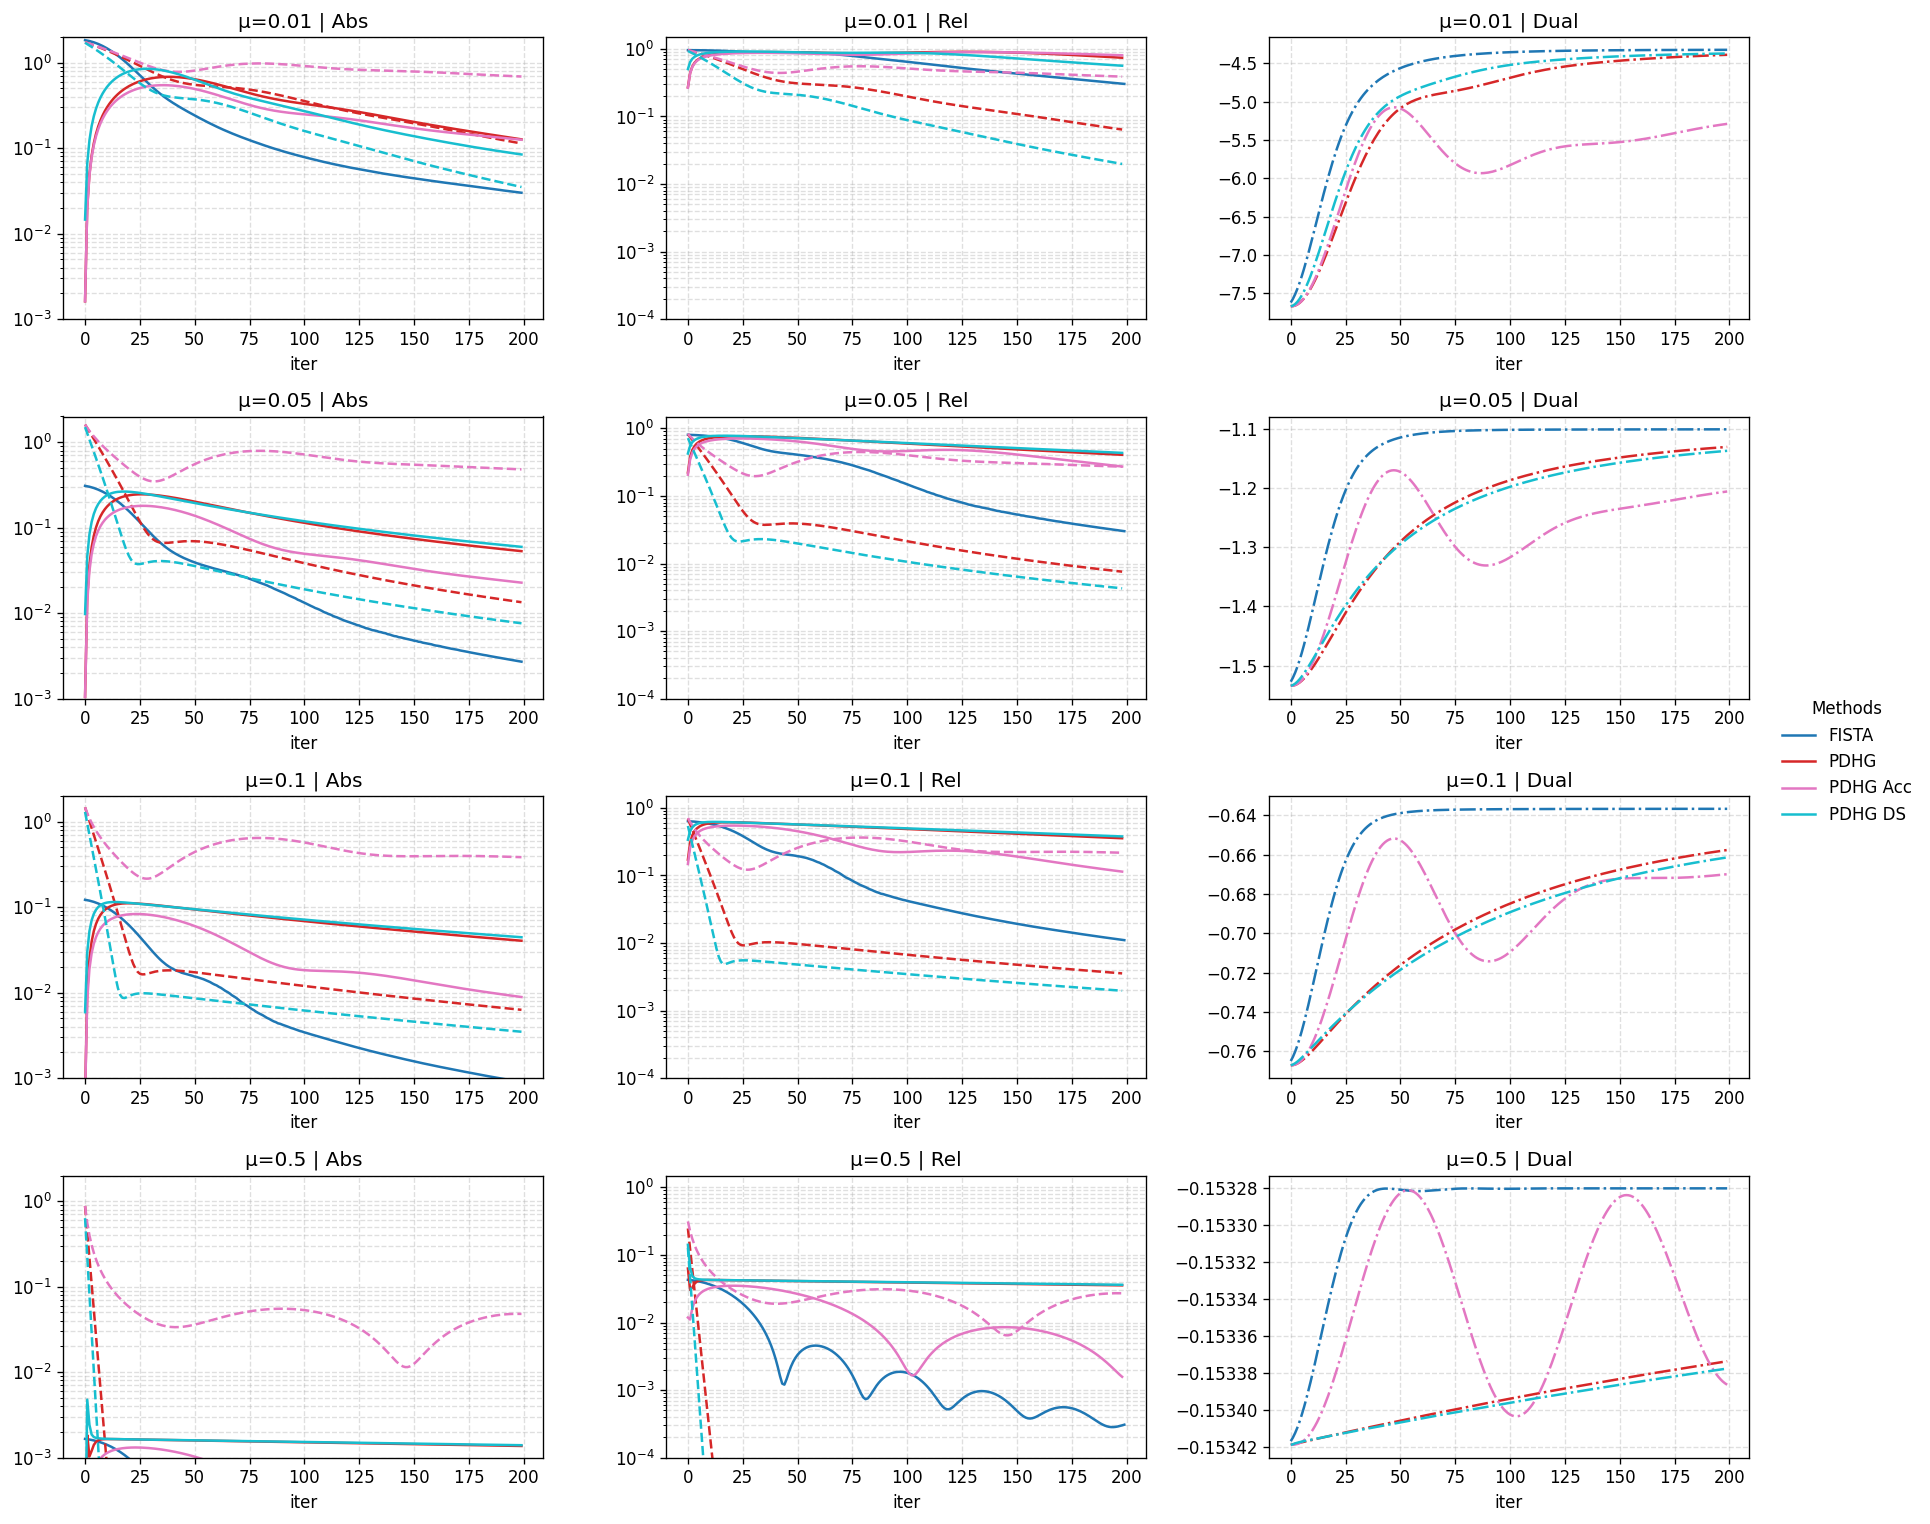

In [7]:
_ = plot_residuals_grid_by_param(residuals, abs_ylim=(1e-3, 2), rel_ylim=(1e-4, 1.5))

#  $m=n=1000$

In [8]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4532e-01, fro_norm=7.0719e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4607e-01, fro_norm=7.0739e+00
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1579e-02, fro_norm=1.2538e-01
A.shape=torch.Size([1000, 1000]), rank_tol=5.0000e+02, sigma_max=1.1613e-02, fro_norm=1.2541e-01
mu_reg=1.9215e-02, lamb_max=1.0003e+01, mu_max=1.9215e+00


In [9]:
residuals = {}
for mu_scale in mu_scales:
    mu_reg = max(mu_scale * mu_max, 1e-6)
    residuals[mu_scale] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.002639502026655


obj (diag scaling):  -0.016349652782082558 
constraint viol (diag scaling):  0.16738257929682726
lamb_max=10.002639502026655
obj (vanilla):  -0.016348619014024734 
constraint viol (vanilla):  0.13467562186997378
lamb_max=10.002639502026655
obj (acceleration):  -0.016300827264785767 
constraint viol (acceleration):  0.0143453255295753
obj (fista):  -0.016339628025889397 
constraint viol (fista):  0.0153441689908504
lamb_max=10.002639502026655
obj (diag scaling):  -0.06707248091697693 
constraint viol (diag scaling):  0.2149661779403686
lamb_max=10.002639502026655
obj (vanilla):  -0.06625326722860336 
constraint viol (vanilla):  0.526450942037627
lamb_max=10.002639502026655
obj (acceleration):  -0.0638832300901413 
constraint viol (acceleration):  0.5390384942293166
obj (fista):  -0.06629133969545364 
constraint viol (fista):  0.43543540616519744
lamb_max=10.002639502026655
obj (diag scaling):  -0.11565466970205307 
constraint viol (diag scaling):  0.9467395031824707
lamb_max=10.00263950

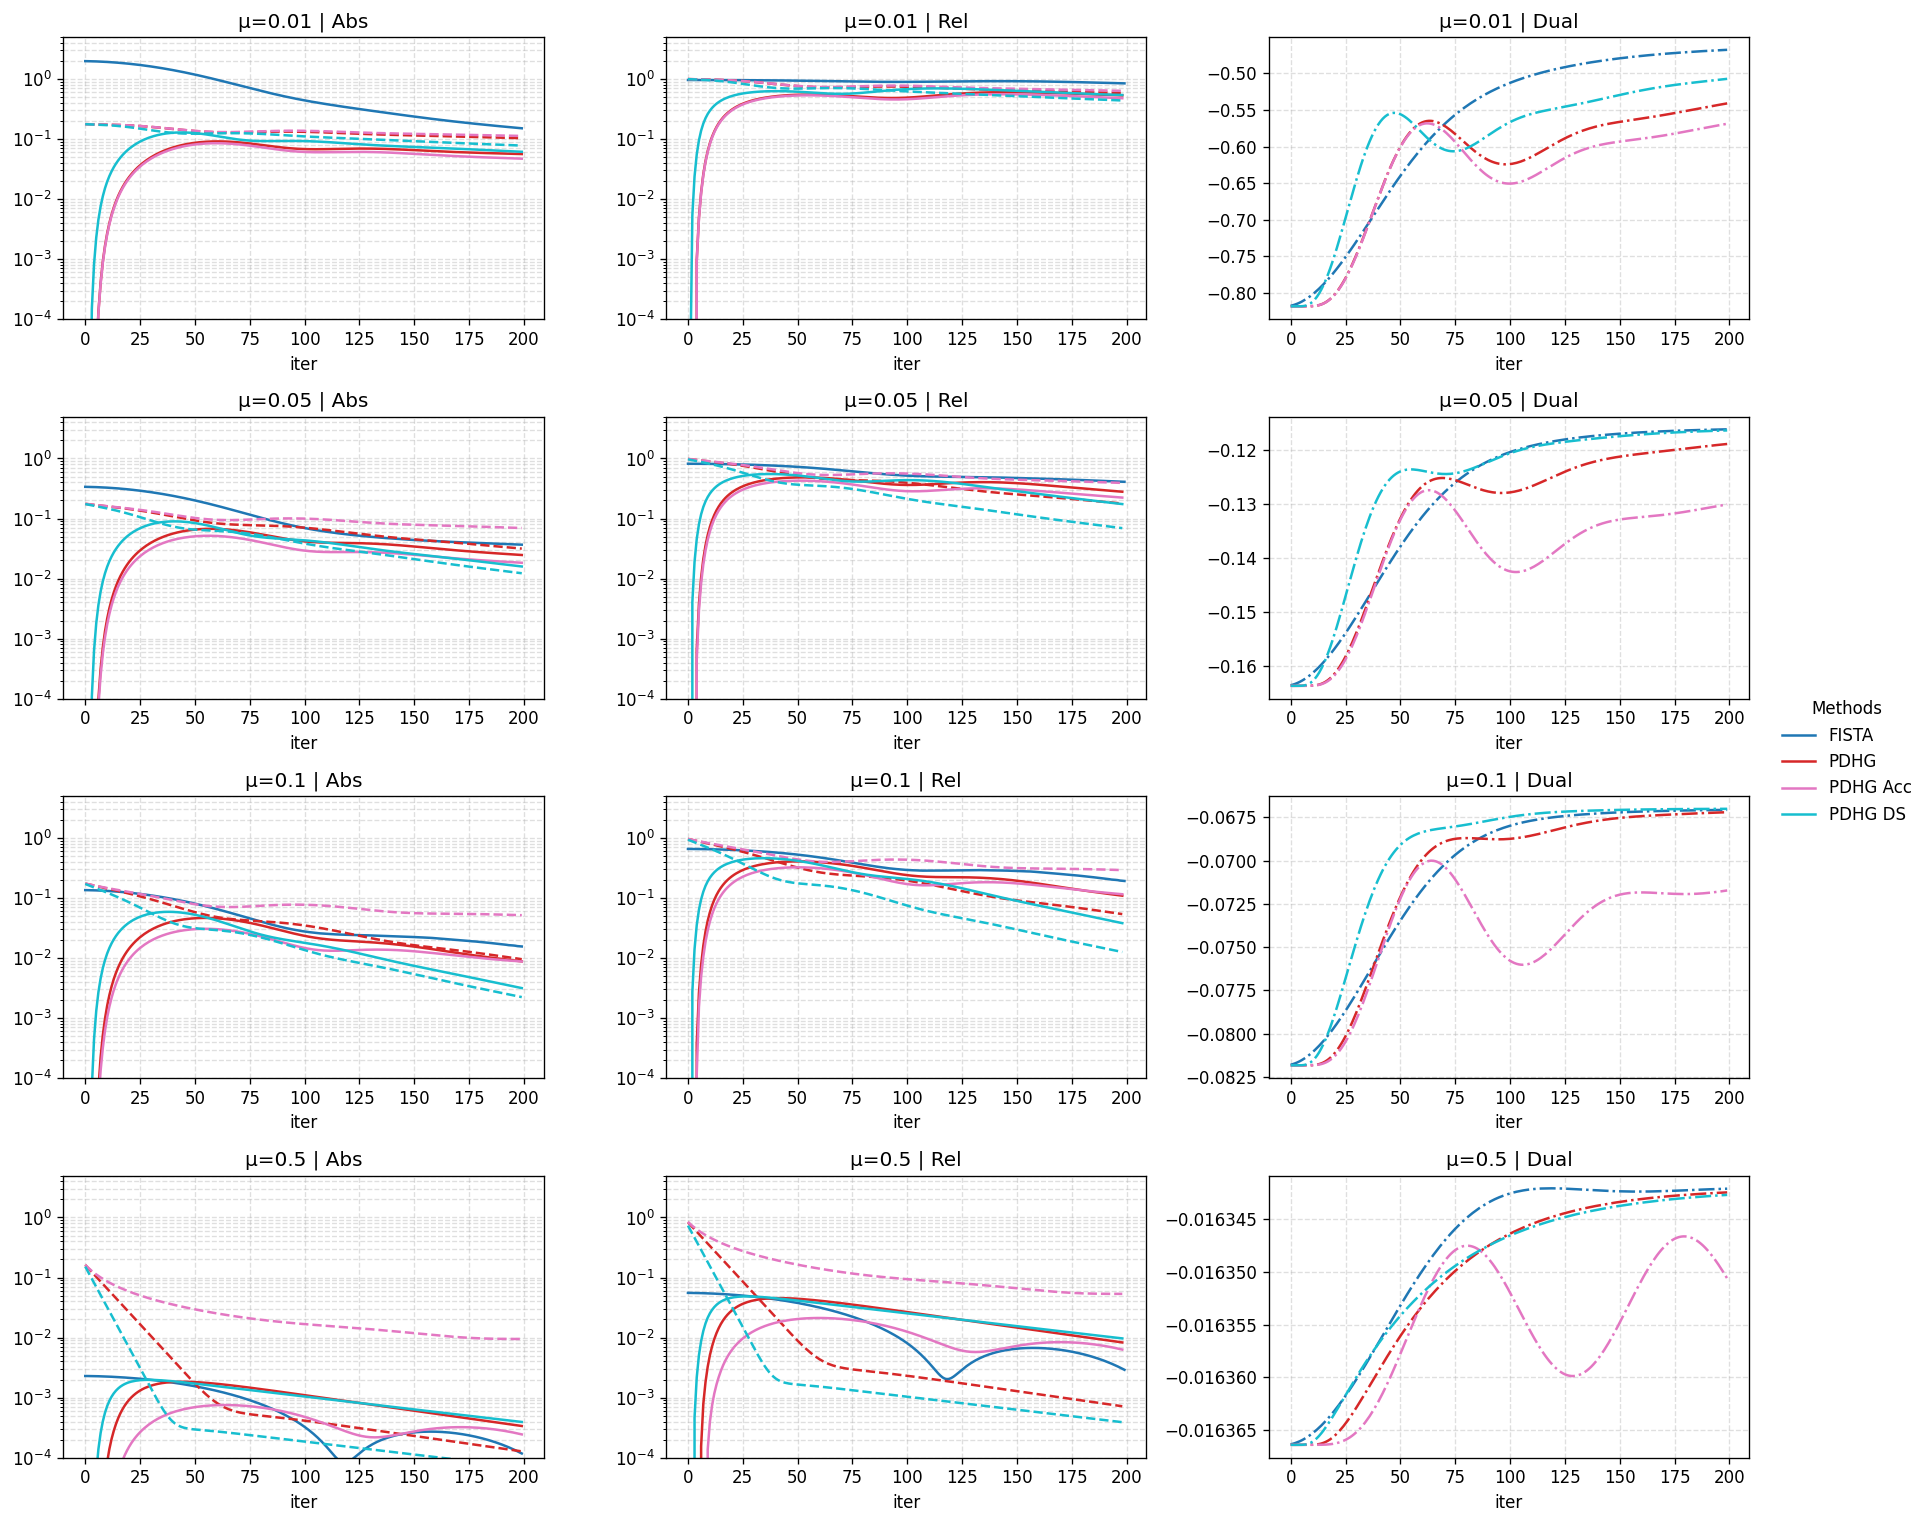

In [10]:
_ = plot_residuals_grid_by_param(residuals, abs_ylim=(1e-4, 5), rel_ylim=(1e-4, 5))